<div style="background:#222222; color:#ffffff; padding:20px">
    <h2 align="center">Deep Learning Fundamentals</h2>
    <h2 align="center" style="color:#01ff84">Multiclass Clasification: MNIST</h2>
<div>

## Imports

In [1]:
#!pip install torch

In [2]:
!pip install torchvision

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchvision import datasets, transforms

## Auxliary plotting function

In [4]:
# https://discuss.pytorch.org/t/view-classify-in-module-helper/30279/6

def view_classify(img, ps):

    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

# Load MNIST Dataset
First up, we need to get our dataset. This is provided through the `torchvision` package. The code below will download the MNIST dataset, then create training and test datasets for us. Don't worry too much about the details here, you'll learn more about this later.

In [5]:
# Define a transform to normalize the data (Preprocessing)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5)) ])

# Download and load the training data
trainset    = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset    = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Extracting MNIST_data/MNIST\raw\train-images-idx3-ubyte.gz to MNIST_data/MNIST\raw


Extracting MNIST_data/MNIST\raw\train-labels-idx1-ubyte.gz to MNIST_data/MNIST\raw



Extracting MNIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST_data/MNIST\raw


Extracting MNIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST\raw
Processing...


C:\Users\kovac\anaconda3\envs\ML_tensorflow\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. We'd use this to loop through the dataset for training, but here I'm just grabbing the first batch so we can check out the data. We can see below that `images` is just a tensor with size (64, 1, 28, 28). So, 64 images per batch, 1 color channel, and 28x28 images.

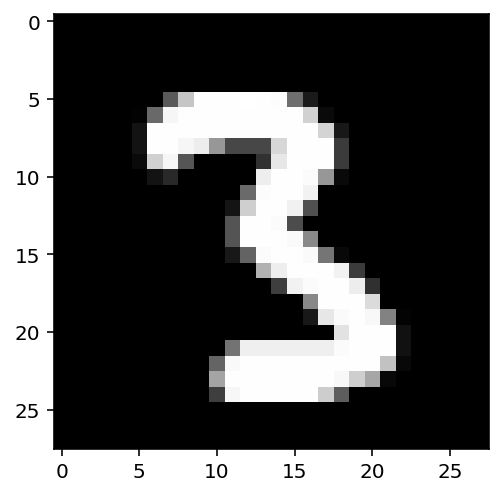

In [7]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

## Building networks with PyTorch

Here I'll use PyTorch to build a simple feedfoward network to classify the MNIST images. That is, the network will receive a digit image as input and predict the digit in the image.

<img src="assets/mlp_mnist.png" width=600px>

To build a neural network with PyTorch, you use the `torch.nn` module. The network itself is a class inheriting from `torch.nn.Module`. You define each of the operations separately, like `nn.Linear(784, 128)` for a fully connected linear layer with 784 inputs and 128 units.

The class needs to include a `forward` method that implements the forward pass through the network. In this method, you pass some input tensor `x` through each of the operations you defined earlier. The `torch.nn` module also has functional equivalents for things like ReLUs in `torch.nn.functional`. This module is usually imported as `F`. Then to use a ReLU activation on some layer (which is just a tensor), you'd do `F.relu(x)`. Below are a few different commonly used activation functions.

<img src="assets/activation.png" width=700px>

So, for this network, I'll build it with three fully connected layers, then a softmax output for predicting classes. The softmax function is similar to the sigmoid in that it squashes inputs between 0 and 1, but it's also normalized so that all the values sum to one like a proper probability distribution.

In [8]:
class Network(nn.Module):
    
    # Defining the layers, 128, 64, 10 units each
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    # Forward pass through the network, returns the output logits
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Sequential API
PyTorch provides a convenient way to build networks like this where a tensor is passed sequentially through operations, `nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). Using this to build the equivalent network:

In [9]:
# Hyperparameters for our network
input_size   = 784
hidden_sizes = [128, 64]
output_size   = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


You can also pass in an `OrderedDict` to name the individual layers and operations. Note that a dictionary keys must be unique, so _each operation must have a different name_.

In [10]:
model = nn.Sequential(OrderedDict([
          ('fc1',   nn.Linear(input_size, hidden_sizes[0])),
          ('relu1', nn.ReLU()),
          ('fc2',   nn.Linear(hidden_sizes[0], hidden_sizes[1])),
          ('relu2', nn.ReLU()),
          ('output', nn.Linear(hidden_sizes[1], output_size)),
          ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

### Initializing weights and biases

The weights and such are automatically initialized for you, but it's possible to customize how they are initialized. The weights and biases are tensors attached to the layer you defined, you can get them with `model.fc1.weight` for instance.

In [11]:
print(model.fc1.weight)
print(model.fc1.bias)

Parameter containing:
tensor([[-0.0148, -0.0078,  0.0153,  ...,  0.0317, -0.0332,  0.0128],
        [ 0.0248,  0.0245, -0.0168,  ..., -0.0282,  0.0252, -0.0281],
        [-0.0142,  0.0215,  0.0249,  ...,  0.0156, -0.0064,  0.0324],
        ...,
        [-0.0258,  0.0088, -0.0027,  ...,  0.0231, -0.0351,  0.0058],
        [-0.0083,  0.0058,  0.0170,  ...,  0.0208, -0.0160, -0.0271],
        [ 0.0260, -0.0056, -0.0118,  ...,  0.0135, -0.0146, -0.0009]],
       requires_grad=True)
Parameter containing:
tensor([-0.0335,  0.0353,  0.0270,  0.0012,  0.0123, -0.0013,  0.0187, -0.0008,
        -0.0052,  0.0041, -0.0035, -0.0352, -0.0165,  0.0348,  0.0262,  0.0200,
        -0.0170,  0.0340,  0.0169, -0.0267,  0.0182, -0.0007, -0.0299,  0.0305,
        -0.0104, -0.0167,  0.0070, -0.0074, -0.0317, -0.0106, -0.0213, -0.0218,
         0.0311, -0.0222,  0.0052,  0.0036,  0.0251,  0.0088, -0.0234, -0.0315,
         0.0274,  0.0303, -0.0132, -0.0348,  0.0029,  0.0205, -0.0032, -0.0236,
         0.0300

For custom initialization, we want to modify these tensors in place. These are actually autograd *Variables*, so we need to get back the actual tensors with `model.fc1.weight.data`. Once we have the tensors, we can fill them with zeros (for biases) or random normal values.

In [12]:
# Set biases to all zeros
model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[-3.6275e-04,  2.9398e-03, -5.8476e-04,  ..., -3.8866e-03,
          1.2438e-03, -1.3611e-03],
        [-2.6389e-03,  1.7455e-02, -1.0590e-03,  ..., -6.8236e-03,
          9.9953e-03,  2.1648e-02],
        [-1.0831e-02,  2.6668e-02,  1.1027e-02,  ..., -2.3688e-03,
         -3.1697e-03,  4.5791e-03],
        ...,
        [ 2.7673e-03, -5.6481e-03, -1.2405e-02,  ...,  1.0705e-03,
          1.4904e-02,  2.8361e-02],
        [-6.4448e-03,  5.1568e-03, -4.5589e-03,  ..., -1.1581e-02,
          1.0635e-03, -7.9892e-05],
        [ 9.0176e-04, -2.7348e-02, -2.1492e-02,  ..., -6.5940e-03,
         -2.8571e-03,  1.2914e-03]])

### STEP 1: Forward pass

Now that we have a network, let's see what happens when we pass in an image. This is called the forward pass. We're going to convert the image data into a tensor, then pass it through the operations defined by the network architecture.

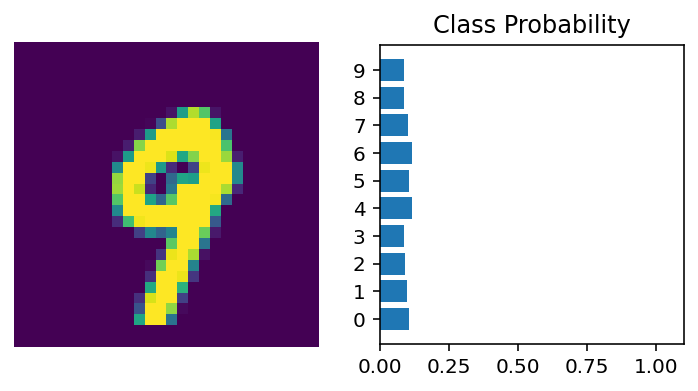

In [14]:
# Grab some data 
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to not automatically get batch size

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
view_classify(img.view(1, 28, 28), ps)

As you can see above, our network has basically no idea what this digit is. It's because we haven't trained it yet, all the weights are random!

# Training Neural Networks

The network we built isn't so smart, it doesn't know anything about our handwritten digits. Neural networks with non-linear activations work like universal function approximators. There is some function that maps your input to the output. For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.

<img src="assets/function_approx.png" width=500px>

At first the network is naive, it doesn't know the function mapping the inputs to the outputs. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

To find these parameters, we need to know how poorly the network is predicting the real outputs. For this we calculate a **loss function** (also called the cost), a measure of our prediction error. For example, the mean squared loss is often used in regression and binary classification problems

$$
\ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy. We find this minimum using a process called **gradient descent**. The gradient is the slope of the loss function and points in the direction of fastest change. To get to the minimum in the least amount of time, we then want to follow the gradient (downwards). You can think of this like descending a mountain by following the steepest slope to the base.

<img src='assets/gradient_descent.png' width=350px>

## Backpropagation

For single layer networks, gradient descent is simple to implement. However, it's more complicated for deeper, multilayer neural networks like the one we've built. Complicated enough that it took about 30 years before researchers figured out how to train multilayer networks, although it's straightforward once you learn about it. 

This is done through **backpropagation** which is really just an application of the chain rule from calculus. It's easiest to understand if we convert a two layer network into a graph representation.

<img src='assets/w1_backprop_graph.png' width=400px>

In the forward pass through the network, our data and operations go from right to left here. To train the weights with gradient descent, we propagate the gradient of the cost backwards through the network. Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.

$$
\frac{\partial \ell}{\partial w_1} = \frac{\partial l_1}{\partial w_1} \frac{\partial s}{\partial l_1} \frac{\partial l_2}{\partial s} \frac{\partial \ell}{\partial l_2}
$$

We update our weights using this gradient with some learning rate $\alpha$. 

$$
w^\prime = w - \alpha \frac{\partial \ell}{\partial w}
$$

The learning rate is set such that the weight update steps are small enough that the iterative method settles in a minimum.

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

## Autograd

Torch provides a module, `autograd`, for automatically calculating the gradient of tensors. It does this by keeping track of operations performed on tensors. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

Also, you can turn on or off gradients altogether with `torch.set_grad_enabled(True|False)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

In [15]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[-0.5838,  1.1479],
        [ 0.6979, -0.3721]], requires_grad=True)


In [16]:
y = x**2
print(y)

tensor([[0.3408, 1.3177],
        [0.4871, 0.1384]], grad_fn=<PowBackward0>)


Below we can see the operation that created `y`, a power operation `PowBackward0`.

In [17]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

The autgrad module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. Let's reduce the tensor `y` to a scalar value, the mean.

In [18]:
z = y.mean()
print(z)

tensor(0.5710, grad_fn=<MeanBackward0>)


You can check the gradients for `x` and `y` but they are empty currently.

In [19]:
print(x.grad)

None


To calculate the gradients, you need to run the `.backward` method on a Variable, `z` for example. This will calculate the gradient for `z` with respect to `x`

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [20]:
z.backward()
print(x.grad)
print(x/2)

tensor([[-0.2919,  0.5739],
        [ 0.3490, -0.1860]])
tensor([[-0.2919,  0.5739],
        [ 0.3490, -0.1860]], grad_fn=<DivBackward0>)


These gradients calculations are particularly useful for neural networks. For training we need the gradients of the weights with respect to the cost. With PyTorch, we run data forward through the network to calculate the cost, then, go backwards to calculate the gradients with respect to the cost. Once we have the gradients we can make a gradient descent step. 

I'll build a network with `nn.Sequential` here. Only difference from the last part is I'm not actually using softmax on the output, but instead just using the raw output from the last layer. This is because the output from softmax is a probability distribution. Often, the output will have values really close to zero or really close to one. Due to [inaccuracies with representing numbers as floating points](https://docs.python.org/3/tutorial/floatingpoint.html), computations with a softmax output can lose accuracy and become unstable. To get around this, we'll use the raw output, called the **logits**, to calculate the loss.

In [21]:
# Hyperparameters for our network
input_size   = 784
hidden_sizes = [128, 64]
output_size  = 10

# Build a feed-forward network
model = nn.Sequential(OrderedDict([
          ('fc1', nn.Linear(input_size, hidden_sizes[0])),
          ('relu1', nn.ReLU()),
          ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
          ('relu2', nn.ReLU()),
          ('logits', nn.Linear(hidden_sizes[1], output_size))]))

## Training the network!

The first thing we need to do for training is define our loss function. In PyTorch, you'll usually see this as `criterion`. Here we're using softmax output, so we want to use `criterion = nn.CrossEntropyLoss()` as our loss. Later when training, you use `loss = criterion(output, targets)` to calculate the actual loss.

We also need to define the optimizer we're using, SGD or Adam, or something along those lines. Here I'll just use SGD with `torch.optim.SGD`, passing in the network parameters and the learning rate.

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

First, let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

Below I'll go through one training step and print out the weights and gradients so you can see how it changes.

In [23]:
print('Initial weights - ', model.fc1.weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model.forward(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model.fc1.weight.grad)
optimizer.step()

Initial weights -  Parameter containing:
tensor([[ 2.9084e-02,  1.8363e-02,  2.8784e-02,  ..., -3.1330e-02,
          9.3185e-03,  2.0464e-02],
        [-1.9945e-03,  1.9823e-02, -1.8608e-02,  ...,  3.0007e-02,
          2.2945e-02, -2.3598e-04],
        [-3.1409e-02, -2.9947e-02, -1.9345e-02,  ...,  9.2402e-03,
         -3.3556e-02,  2.3346e-05],
        ...,
        [-2.2001e-02, -1.2827e-02,  1.4273e-02,  ...,  5.1373e-03,
          3.2451e-02,  3.1318e-02],
        [ 3.2242e-02,  9.9277e-03, -8.3516e-04,  ...,  1.4982e-02,
         -2.0092e-02,  2.4140e-02],
        [ 1.3667e-02,  2.7407e-02, -2.5724e-02,  ...,  1.6883e-02,
          3.2473e-02, -2.0877e-02]], requires_grad=True)
Gradient - tensor([[-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002],
        [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
        [-0.0026, -0.0026, -0.0026,  ..., -0.0026, -0.0026, -0.0026],
        ...,
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
   

In [24]:
print('Updated weights - ', model.fc1.weight)

Updated weights -  Parameter containing:
tensor([[ 2.9087e-02,  1.8365e-02,  2.8786e-02,  ..., -3.1327e-02,
          9.3209e-03,  2.0467e-02],
        [-1.9960e-03,  1.9822e-02, -1.8610e-02,  ...,  3.0005e-02,
          2.2943e-02, -2.3755e-04],
        [-3.1384e-02, -2.9922e-02, -1.9320e-02,  ...,  9.2657e-03,
         -3.3530e-02,  4.8912e-05],
        ...,
        [-2.2006e-02, -1.2832e-02,  1.4267e-02,  ...,  5.1319e-03,
          3.2446e-02,  3.1313e-02],
        [ 3.2248e-02,  9.9338e-03, -8.2900e-04,  ...,  1.4988e-02,
         -2.0086e-02,  2.4146e-02],
        [ 1.3700e-02,  2.7441e-02, -2.5690e-02,  ...,  1.6916e-02,
          3.2506e-02, -2.0843e-02]], requires_grad=True)


### Training for real

Now we'll put this algorithm into a loop so we can go through all the images. This is fairly straightforward. We'll loop through the mini-batches in our dataset, pass the data through the network to calculate the losses, get the gradients, then run the optimizer.

In [25]:
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [26]:
epochs = 3
print_every = 40

for e in range(epochs):
    running_loss = 0
    print(f"Epoch: {e+1}/{epochs}")

    for i, (images, labels) in enumerate(iter(trainloader)):

        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        output = model.forward(images)   # 1) Forward pass
        loss = criterion(output, labels) # 2) Compute loss
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += loss.item()
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0

Epoch: 1/3
	Iteration: 0	 Loss: 0.0581
	Iteration: 40	 Loss: 2.3022
	Iteration: 80	 Loss: 2.2830
	Iteration: 120	 Loss: 2.2601
	Iteration: 160	 Loss: 2.2402
	Iteration: 200	 Loss: 2.2193
	Iteration: 240	 Loss: 2.1972
	Iteration: 280	 Loss: 2.1734
	Iteration: 320	 Loss: 2.1485
	Iteration: 360	 Loss: 2.1157
	Iteration: 400	 Loss: 2.0864
	Iteration: 440	 Loss: 2.0430
	Iteration: 480	 Loss: 2.0037
	Iteration: 520	 Loss: 1.9569
	Iteration: 560	 Loss: 1.9180
	Iteration: 600	 Loss: 1.8716
	Iteration: 640	 Loss: 1.8068
	Iteration: 680	 Loss: 1.7592
	Iteration: 720	 Loss: 1.6842
	Iteration: 760	 Loss: 1.6198
	Iteration: 800	 Loss: 1.5663
	Iteration: 840	 Loss: 1.5217
	Iteration: 880	 Loss: 1.4488
	Iteration: 920	 Loss: 1.3841
Epoch: 2/3
	Iteration: 0	 Loss: 0.0346
	Iteration: 40	 Loss: 1.2906
	Iteration: 80	 Loss: 1.2598
	Iteration: 120	 Loss: 1.1882
	Iteration: 160	 Loss: 1.1578
	Iteration: 200	 Loss: 1.1072
	Iteration: 240	 Loss: 1.0661
	Iteration: 280	 Loss: 1.0215
	Iteration: 320	 Loss: 0.9

With the network trained, we can check out it's predictions.

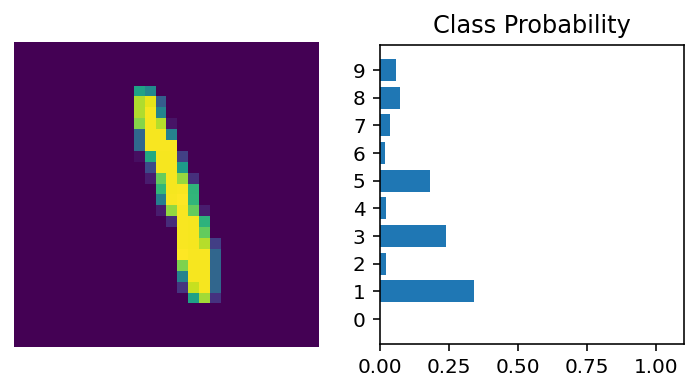

In [27]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
view_classify(img.view(1, 28, 28), ps)

Now our network is brilliant. It can accurately predict the digits in our images.

<div style="background:#222222; color:#ffffff; padding:20px">
    <h2 align="center" style="color:#01ff84">MNIST Clasification: Exercise</h2>
<div>

<div style="background:#222222; color:#ffffff; padding:20px">
  <h3 style="color:#01ff84; margin-top:4px">Exercise 1:</h3>
  <p>Now it's your turn to build a simple network, use any method I've covered so far. In the next notebook, you'll learn how to train a network so it can make good predictions.</p>
  <p>Build a network to classify the MNIST images with 3 hidden layers. Use 400 units in the first hidden layer, 200 units in the second layer, and 100 units in the third layer. Each hidden layer should have a ReLU activation function, and use softmax on the output layer.</p>
<div>

In [29]:
## TODO: Your network here
## TODO: Your network here
class Network(nn.Module):
    
    # Defining the layers, 128, 64, 10 units each
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 10)

        
    # Forward pass through the network, returns the output logits
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.softmax(x, dim=1)
        return x

model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

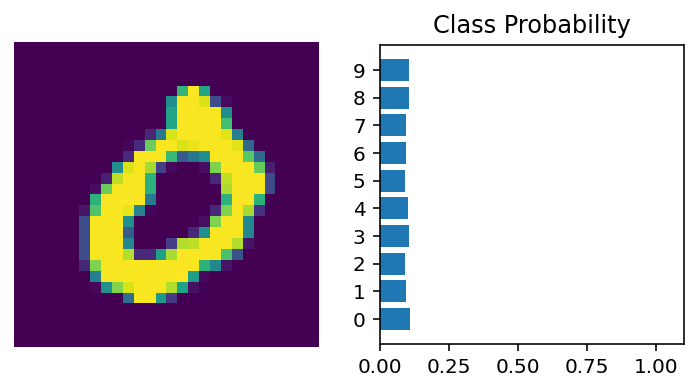

In [33]:
# Run this cell with your model to make sure it works
# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
view_classify(images[0].view(1, 28, 28), ps)

<div style="background:#222222; color:#ffffff; padding:20px">
  <h3 style="color:#01ff84; margin-top:4px">Exercise 2:</h3>
  <p>Train your network implementing the Pytorch training loop and <strong style="color:#01ff84">after each epoch, use the model for predicting the test (validation) MNIST data.</strong></p>
  <p>Note: If your model does not fit with the final softmax layer, you can remove this layer.</p>
  <p>Hint: <a href="https://discuss.pytorch.org/t/training-loop-checking-validation-accuracy/78399">Training loop checking validation accuracy
</a></p>
  <p>Research about <code>model.train()</code>, <code>model.eval()</code> and <code>with torch.no_grad()</code> in Pytorch.
<div>

In [37]:
model.train()

Network(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

In [38]:
model.eval()

Network(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
)

In [41]:
optimizer = optim.SGD(model.parameters(), lr=0.05)

In [42]:
## TODO: Your training loop here

epochs = 3
print_every = 40

correct = 0
total = 0

for e in range(epochs):
    running_loss = 0
    print(f"Epoch: {e+1}/{epochs}")

    for i, (images, labels) in enumerate(iter(trainloader)):

        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        output = model.forward(images)   # 1) Forward pass
        loss = criterion(output, labels) # 2) Compute loss
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += loss.item()
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0
            
    with torch.no_grad():
        for data in testloader:
            output = model.forward(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print((100 * correct / total))

Epoch: 1/3
	Iteration: 0	 Loss: 0.0541
	Iteration: 40	 Loss: 2.1223
	Iteration: 80	 Loss: 2.0926
	Iteration: 120	 Loss: 2.0400
	Iteration: 160	 Loss: 1.9997
	Iteration: 200	 Loss: 1.9392
	Iteration: 240	 Loss: 1.9291
	Iteration: 280	 Loss: 1.8954
	Iteration: 320	 Loss: 1.8799
	Iteration: 360	 Loss: 1.8671
	Iteration: 400	 Loss: 1.8586
	Iteration: 440	 Loss: 1.8485
	Iteration: 480	 Loss: 1.8382
	Iteration: 520	 Loss: 1.8210
	Iteration: 560	 Loss: 1.8276
	Iteration: 600	 Loss: 1.8115
	Iteration: 640	 Loss: 1.7975
	Iteration: 680	 Loss: 1.7948
	Iteration: 720	 Loss: 1.7812
	Iteration: 760	 Loss: 1.7497
	Iteration: 800	 Loss: 1.7572
	Iteration: 840	 Loss: 1.7270
	Iteration: 880	 Loss: 1.7359
	Iteration: 920	 Loss: 1.7342
75.0
Epoch: 2/3
	Iteration: 0	 Loss: 0.0433
	Iteration: 40	 Loss: 1.7146
	Iteration: 80	 Loss: 1.6985
	Iteration: 120	 Loss: 1.6918
	Iteration: 160	 Loss: 1.6769
	Iteration: 200	 Loss: 1.6916
	Iteration: 240	 Loss: 1.6896
	Iteration: 280	 Loss: 1.6662
	Iteration: 320	 Loss

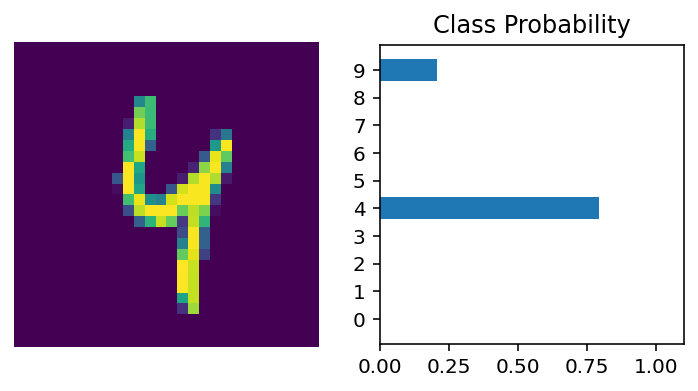

In [44]:
# Run this cell with your model to make sure it works and predicts well for the validation data
images, labels = next(iter(testloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
view_classify(images[0].view(1, 28, 28), ps)

<div style="background:#222222; color:#ffffff; padding:20px">
  <h3 style="color:#01ff84; margin-top:4px">Exercise 3:</h3>
  <p>Write the code for adding <strong style="color:#01ff84">Early Stopping with patience = 2</strong> to the training loop from scratch.</p>
  <p><strong style="color:#01ff84">Hint:</strong> Monitor the Validation loss every epoch, and if in 2 epochs, the validation loss does not improve, stop the training loop with <code>break</code>.</p>
<div>

In [ ]:
## TODO: Your network here
## TODO: Your network here
class Network(nn.Module):
    
    # Defining the layers, 128, 64, 10 units each
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 10)

        
    # Forward pass through the network, returns the output logits
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.softmax(x, dim=1)
        return x

model = Network()
model

In [48]:
## TODO: Your training loop here

epochs = 3
print_every = 40

correct = 0
total = 0

for e in range(epochs):
    running_loss = 0
    print(f"Epoch: {e+1}/{epochs}")

    for i, (images, labels) in enumerate(iter(trainloader)):

        # Flatten MNIST images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        output = model.forward(images)   # 1) Forward pass
        loss = criterion(output, labels) # 2) Compute loss
        loss.backward()                  # 3) Backward pass
        optimizer.step()                 # 4) Update model
        
        running_loss += loss.item()
        
        if i % print_every == 0:
            print(f"\tIteration: {i}\t Loss: {running_loss/print_every:.4f}")
            running_loss = 0
            
    with torch.no_grad():
        for images, labels in iter(testloader):
            print(images.shape, labels.shape)
            loss = criterion(output, labels)
            output = model.forward(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print((100 * correct / total))
    

Epoch: 1/3
	Iteration: 0	 Loss: 0.0384
	Iteration: 40	 Loss: 1.5288
	Iteration: 80	 Loss: 1.5288
	Iteration: 120	 Loss: 1.5322
	Iteration: 160	 Loss: 1.5333
	Iteration: 200	 Loss: 1.5303
	Iteration: 240	 Loss: 1.5312
	Iteration: 280	 Loss: 1.5402
	Iteration: 320	 Loss: 1.5350
	Iteration: 360	 Loss: 1.5318
	Iteration: 400	 Loss: 1.5293
	Iteration: 440	 Loss: 1.5318
	Iteration: 480	 Loss: 1.5306
	Iteration: 520	 Loss: 1.5276
	Iteration: 560	 Loss: 1.5330
	Iteration: 600	 Loss: 1.5236
	Iteration: 640	 Loss: 1.5327
	Iteration: 680	 Loss: 1.5188
	Iteration: 720	 Loss: 1.5312
	Iteration: 760	 Loss: 1.5301
	Iteration: 800	 Loss: 1.5318
	Iteration: 840	 Loss: 1.5280
	Iteration: 880	 Loss: 1.5215
	Iteration: 920	 Loss: 1.5253
torch.Size([64, 1, 28, 28]) torch.Size([64])


ValueError: Expected input batch_size (32) to match target batch_size (64).